In [38]:
#%reset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, auc 
from sklearn.preprocessing import OneHotEncoder
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from matplotlib.font_manager import FontProperties



In [16]:
def determine_covid_outcome_indicator(new_cases_per_100k, new_admits_per_100k, percent_beds_100k):
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 0.10): 
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return 1
            else:
                return 0
        else:
            return 0
    elif new_cases_per_100k >= 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k >= 0.10):  
                return 1
        elif (new_admits_per_100k < 10) | (percent_beds_100k < 10):
                return 1


In [17]:
def merge_and_rename_data(data1, data2, on_column, suffix1, suffix2):
    merged_data = pd.merge(data1, data2, on=on_column, suffixes=('_'+suffix1, '_'+suffix2))

    new_column_names = [col.replace(f'_{on_column}_{suffix1}', f'_{suffix1}').replace(f'_{on_column}_{suffix2}', f'_{suffix2}') for col in merged_data.columns]
    merged_data.rename(columns=dict(zip(merged_data.columns, new_column_names)), inplace=True)

    return merged_data

def pivot_data_by_HSA(data, index_column, columns_column, values_column):
    data_by_HSA = data[[index_column, columns_column, values_column]]
    pivot_table = data_by_HSA.pivot_table(index=index_column, columns=columns_column, values=values_column)
    return pivot_table

def create_column_names(categories_for_subsetting, num_of_weeks):
    column_names = ['HSA_ID']

    for week in range(1, num_of_weeks + 1):
        week = num2words(week)
        for category in categories_for_subsetting:
            column_name = f'week_{week}_{category}'
            column_names.append(column_name)

    return column_names
    
def create_collated_weekly_data(pivoted_table, original_data, categories_for_subsetting, geography, column_names):
    collated_data = pd.DataFrame(index=range(51), columns=column_names)

    x = 0
    for geo in original_data[geography].unique():
        #matching_indices = [i for i, geo_col in enumerate(pivoted_table) if geo_col == geo]
        collated_data.loc[x, geography] = geo
        columns_to_subset = [f'{geo}_{category}' for category in categories_for_subsetting]
        j = 1
        try:
            for row in range(len(pivoted_table.loc[:, columns_to_subset])):
                collated_data.iloc[x, j:j + len(categories_for_subsetting)] = pivoted_table.loc[row, columns_to_subset]
                j += len(categories_for_subsetting)
        except:
            pass
        x += 1

    return collated_data


def add_changes_by_week(weekly_data_frame, outcome_column):

    for column in weekly_data_frame.columns[1:]:
        # Calculate the difference between each row and the previous row
        if outcome_column not in column.lower(): #want to leave out the outcome column
            diff = weekly_data_frame[column].diff()
            
            # Create a new column with the original column name and "delta"
            new_column_name = column + "_delta"
            
            column_index = weekly_data_frame.columns.get_loc(column)
            
            # Insert the new column just after the original column
            weekly_data_frame.insert(column_index + 1, new_column_name, diff)
            weekly_data_frame[new_column_name] = diff
    return weekly_data_frame


def prep_training_test_data_period(data, no_weeks, weeks_in_futre, if_train, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    y_weeks_to_check = [] #check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        for week_y in range(week+1, test_week+1):
                y_weeks_to_check.append('_' + num2words(week_y) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    k = 0
    for x_week in x_weeks:
            y_week = y_weeks[k]
            k +=1

            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
            train_week = w2n.word_to_num(x_week.replace("_", ""))
            target_week =  w2n.word_to_num(y_week.replace("_", ""))
            y_weeks_to_check = []
            for week_to_check in range(train_week + 1, target_week + 1):
                y_weeks_to_check.append('_' + num2words(week_to_check) + '_')

            y_weeks_to_check = [week + 'beds_over_15_100k' for week in y_weeks_to_check]
            columns_to_check = [col for col in data.columns if any(week in col for week in y_weeks_to_check)]
            y_over_in_period = data[columns_to_check].apply(max, axis=1)
            data_y = pd.concat([data_y, y_over_in_period], axis=1)
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and  "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week
            y_week.columns = range(1, len(data_y.columns) -2)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)


def prep_training_test_data(data, no_weeks, weeks_in_futre, if_train, geography, weight_col, keep_output):
## Get the weeks for the x and y datasets   
    x_weeks = []  
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_futre
        x_weeks.append('_' + num2words(week) + '_')
        y_weeks.append('_' + num2words(test_week) + '_')
    
## Divide up the test/train split
    #if is_geographic:
        # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
        # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all =  pd.DataFrame()
    missing_data = []
    ## Now get the training data 
    for x_week in x_weeks:
            y_week = y_weeks[0]
            weeks_x = [col for col in data.columns if x_week in col]
            columns_x  = [geography] + weeks_x + [weight_col]
            data_x = data[columns_x]

            weeks_y = [col for col in data.columns if y_week in col]
            columns_y  = [geography] + weeks_y
            data_y = data[columns_y]
            # ensure they have the same amount of data
            #remove rows in test_data1 with NA in test_data2
            data_x = data_x.dropna()
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            # remove rows in test_data2 with NA in test_data1
            data_y = data_y.dropna()
            data_y = data_y[data_y[geography].isin(data_x[geography])]
            data_x = data_x[data_x[geography].isin(data_y[geography])]
            data_x_no_HSA = len(data_x[geography].unique())

            missing_data.append(((len(data[geography].unique()) - data_x_no_HSA)/len(data[geography].unique())) * 100)
            # get weights 
            #weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

            X_week = data_x.iloc[:, 1:len(columns_x)]  # take away y, leave weights for mo
            y_week = data_y.iloc[:, -1] 
            
            y_week = y_week.astype(int)
            if if_train:

                 X_week, y_week = oversample.fit_resample(X_week, y_week)
            weights = X_week.iloc[:, -1] 
            if keep_output:
                X_week = X_week.iloc[:, :len(X_week.columns)-1] # remove the weights and leave "target" for that week

                #rename columns for concatenation 
                X_week.columns = range(1, len(data_x.columns) -1)
            else:
                X_week = X_week.iloc[:, :len(X_week.columns)-2] # remove the weights and  "target" for that week

                X_week.columns = range(1, len(data_x.columns) -2)# remove the weights and  "target" for that week

                #rename columns for concatenation 
            y_week.columns = range(1, len(data_y.columns) -1)
            X_data = pd.concat([X_data, X_week])
            y_data = pd.concat([y_data, y_week]) 
        
            weights_all =  pd.concat([weights_all, weights]) 


    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return(X_data, y_data, weights_all, missing_data)

def calculate_ppv_npv(confusion_matrix):
    # Extract values from the confusion matrix
    TP = confusion_matrix[1, 1]
    FP = confusion_matrix[0, 1]
    TN = confusion_matrix[0, 0]
    FN = confusion_matrix[1, 0]

    # Calculate PPV (Precision) and NPV
    ppv = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0.0

    return ppv, npv

Data prep
For the CDC, they only use three metrics: new_cases_per_100k, new_admits_per_100k, percent_beds_100k

In [18]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')
data_by_HSA['health_service_area_number']
data_by_HSA['health_service_area']
#data_by_HSA['HSA_ID'] = data_by_HSA['health_service_area_number'].astype(str) + '' + data_by_HSA['health_service_area'].apply(lambda x: x.split()[0])
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

data_by_HSA['beds_over_15_100k'] = (data_by_HSA['beds_weekly'] > 15)*1

# remove HSAs that have missing data in specific columns

data_by_HSA = data_by_HSA.dropna(subset=['admits_weekly', 'deaths_weekly', 'cases_weekly', 'icu_weekly', 'beds_weekly', 'perc_covid'])

/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_51666/3165355871.py:1: DtypeWarning: Columns (41,43,44,45,46,50,51) have mixed types. Specify dtype option on import or set low_memory=False.
  data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates.csv')


In [19]:

for i, week in enumerate(data_by_HSA['date'].unique()):
    data_by_HSA.loc[data_by_HSA['date'] == week, 'week'] = i

In [20]:
## pivot 
data_by_HSA_cases = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'cases_weekly')
data_by_HSA_admissions = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'admits_weekly')
data_by_HSA_percent_beds = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'perc_covid')
data_by_HSA_over_15_100k = pivot_data_by_HSA(data_by_HSA, 'week', 'HSA_ID', 'beds_over_15_100k')

## merge 
data_by_HSA_cases_admits = merge_and_rename_data(data_by_HSA_cases, data_by_HSA_admissions,'week','cases', 'admits')
data_by_HSA_admits_perc_outcome = merge_and_rename_data(data_by_HSA_percent_beds, data_by_HSA_over_15_100k,'week','perc_covid', 'beds_over_15_100k')
data_by_HSA_cases_admits_perc_outcome= pd.merge(data_by_HSA_cases_admits, data_by_HSA_admits_perc_outcome, on='week')


data_by_HSA_cases_admits_perc_outcome = data_by_HSA_cases_admits_perc_outcome.reset_index()
data_by_HSA_cases_admits_perc_outcome.columns = data_by_HSA_cases_admits_perc_outcome.columns.str.replace(',', '')

In [21]:
categories_for_subsetting = ['cases', 'admits','perc_covid', 'beds_over_15_100k']
num_of_weeks = len(data_by_HSA_cases_admits_perc_outcome)
column_names = create_column_names(categories_for_subsetting, num_of_weeks)

In [22]:
all_HSA_ID_weekly_data = create_collated_weekly_data(data_by_HSA_cases_admits_perc_outcome, data_by_HSA, categories_for_subsetting, 'HSA_ID', column_names)

In [23]:
weights_df = data_by_HSA[data_by_HSA['HSA_ID'].isin(all_HSA_ID_weekly_data['HSA_ID'])][['HSA_ID','weight_alt']]
weights_df = weights_df.rename(columns = {'HSA_ID': 'HSA_ID', 'weight_alt':'weight'})
weights_df = weights_df.drop_duplicates()
weights_df['weight'].unique()
all_HSA_ID_weekly_data = all_HSA_ID_weekly_data.join(weights_df['weight'])

Looking at all weeks

In [24]:
indicators, actual_outcome, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks = range(1, 123), weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)
weights = weights[0].to_numpy()

Just compare the High vs >15 per 100k in the week of interest (no time lag)

# Get CDC predictions from the X data
 y data is the actual outcome

In [26]:
CDC_predictions = pd.DataFrame(index=data_by_HSA_cases_admits_perc_outcome['week'])

for idx, row in indicators.iterrows():
    outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
    CDC_predictions.at[idx, 0] = outcome

In [27]:
comparison_result = actual_outcome.values == CDC_predictions.values
correct_predictions = comparison_result.sum()

# Calculate the total number of predictions (total number of elements in the DataFrames)
total_predictions = actual_outcome.size
accuracy = correct_predictions / total_predictions
print(accuracy)

auroc = roc_auc_score(actual_outcome,CDC_predictions)
print(auroc)

0.48180921255472653
0.5092631616895577


In [28]:
# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)
conf_matrix = confusion_matrix(actual_outcome,CDC_predictions)

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Calculate specificity (true negative rate)
specificity = TN / (TN + FP)
print(specificity)
# Calculate sensitivity (true positive rate)
sensitivity = TP / (TP + FN)
print(sensitivity)

ppv, npv = calculate_ppv_npv(conf_matrix)
print(ppv)
print(npv)

0.5934736200060994
0.42505270337301587
0.6728914627861893
0.34411416243744586


# Directly compare probability that it will be "high" and >15 per 100k

In [29]:
def determine_covid_outcome_indicator(new_cases_per_100k, new_admits_per_100k, percent_beds_100k):
    if new_cases_per_100k < 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k > 0.10):  # Changed .10 to 0.10
            if (new_admits_per_100k >= 20) | (percent_beds_100k >= 15):
                return "High"
            else:
                return "Medium"
        else:
            return "Low" 
    elif new_cases_per_100k >= 200:
        if (new_admits_per_100k >= 10) | (percent_beds_100k >= 0.10):  # Changed .10 to 0.10
                return "High"
        elif (new_admits_per_100k < 10) | (percent_beds_100k < 10):
                return  "Medium"


For all weeks

In [30]:
CDC_predictions_levels = pd.DataFrame(index=data_by_HSA_cases_admits_perc_outcome['week'])

for idx, row in indicators.iterrows():
    outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
    CDC_predictions_levels.at[idx, 0] = outcome

How many were predicted low/medium/high that ended up like that 

In [31]:

# Calculate the percentage of cases where the predicted CDC risk level is 'High' and actual outcome is 1
sum_high_and_1 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 1))
total_high_predictions = np.sum(CDC_predictions_levels == 'High')
percentage_high_and_1 = (sum_high_and_1 / total_high_predictions) * 100
print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
sum_med_and_1 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 1))
total_med_predictions = np.sum(CDC_predictions_levels == 'Medium')
percentage_med_and_1 = (sum_med_and_1 / total_med_predictions) * 100
print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))

# Calculate the percentage of cases where the predicted CDC risk level is 'Low' and actual outcome is 1
sum_low_and_1 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 1))
total_low_predictions = np.sum(CDC_predictions_levels == 'Low')
percentage_low_and_1 = (sum_low_and_1 / total_low_predictions) * 100
print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))

Percentage High and 1: 69.67%
Percentage Medium and 1: 66.08%
Percentage Low and 1: 63.76%


/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_51666/831232160.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage High and 1: {:.2f}%".format(float(percentage_high_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_51666/831232160.py:11: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Medium and 1: {:.2f}%".format(float(percentage_med_and_1)))
/var/folders/d4/chxwf4hs5kq7ttsp56s64z65mjk3qj/T/ipykernel_51666/831232160.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print("Percentage Low and 1: {:.2f}%".format(float(percentage_low_and_1)))


In [33]:
replacement_map = {'Low': 0, 'Medium': 0, 'High': 1}

# Replace values in the 'CDC_predictions_levels' column
CDC_predictions_levels_binary = CDC_predictions_levels[0].replace(replacement_map)
# Calculate the True Positive Rate (Sensitivity) and False Positive Rate for different levels
tpr_high = sum_high_and_1 / total_high_predictions
fpr_high = (total_high_predictions - sum_high_and_1) / total_high_predictions

tpr_med = (total_med_predictions - sum_med_and_1) / total_med_predictions
fpr_med = sum_med_and_1 / total_med_predictions

tpr_low = (total_low_predictions - sum_low_and_1) / total_low_predictions
fpr_low = sum_low_and_1 / total_low_predictions

# Create ROC curve points
roc_points = [(fpr_low, tpr_low), (fpr_med, tpr_med), (fpr_high, tpr_high)]

# Calculate AUROC score
auroc_score = roc_auc_score(actual_outcome, CDC_predictions_levels_binary)

In [34]:
auroc_score

0.5267445721283711

For each week 

In [239]:
weeks = range(1, 120)
sum_high_and_1_list = []
sum_med_and_1_list = []
sum_low_and_1_list = []
actual_1_list = []

for week in weeks:
    indicators, actual_outcome, weights, missing_data_train_HSA = prep_training_test_data(all_HSA_ID_weekly_data,  no_weeks=[week], weeks_in_futre = 3, if_train = False, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)
    CDC_predictions_levels = pd.DataFrame(index=data_by_HSA_cases_admits_perc_outcome['week'])

    for idx, row in indicators.iterrows():
        outcome = determine_covid_outcome_indicator(row[1], row[2], row[3])
        CDC_predictions_levels.at[idx, 0] = outcome
    
    # Calculate the percentage of cases where the predicted CDC risk level is 'High' and actual outcome is 1
    sum_high_and_1 = np.sum((CDC_predictions_levels == 'High') & (actual_outcome == 1))
    total_high_predictions = np.sum(CDC_predictions_levels == 'High')
    sum_high_and_1_list.append((sum_high_and_1 / total_high_predictions) * 100)
    # Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
    sum_medium_and_1 = np.sum((CDC_predictions_levels == 'Medium') & (actual_outcome == 1))
    total_medium_predictions = np.sum(CDC_predictions_levels == 'Medium')
    sum_med_and_1_list.append((sum_medium_and_1 / total_medium_predictions) * 100)    
    # Calculate the percentage of cases where the predicted CDC risk level is 'Medium' and actual outcome is 1
    sum_low_and_1 = np.sum((CDC_predictions_levels == 'Low') & (actual_outcome == 1))
    total_low_predictions = np.sum(CDC_predictions_levels == 'Low')
    sum_low_and_1_list.append((sum_low_and_1 / total_low_predictions) * 100)    
    
    # Calculate the percentage of cases where the actual outcome is 1
    actual_1_list.append(actual_outcome.sum() / len(actual_outcome) * 100)


In [216]:
sum_high_med_and_1 = [x + y for x,y in zip(sum_high_and_1, sum_med_and_1)]

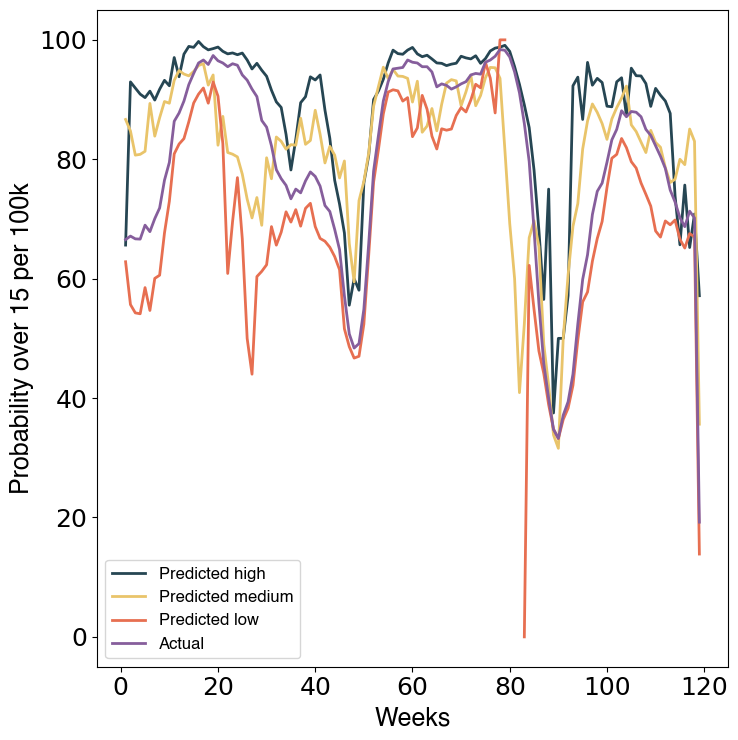

In [246]:
fig, axs = plt.subplots(figsize=(7.5, 7.5), facecolor='w', edgecolor='k', sharex = 'all', sharey = 'all')
colors = ['#264653', '#2a9d8f', '#e9c46a', '#f4a261', '#e76f51', '#865e9c']
axs.tick_params(axis='both', which='major', labelsize=18)
hfont = {'fontname':'Helvetica'}

axs.plot(weeks, sum_high_and_1_list, color = colors[0], linewidth=2, label = 'Predicted high')
axs.plot(weeks, sum_med_and_1_list, color = colors[2], linewidth=2, label = 'Predicted medium')
axs.plot(weeks, sum_low_and_1_list, color = colors[4], linewidth=2, label = 'Predicted low')
axs.plot(weeks, actual_1_list, color = colors[5],  linewidth=2, label = 'Actual')
axs.legend()
axs.set_xlabel("Weeks",  fontsize = 18, **hfont)
axs.set_ylabel("Probability over 15 per 100k",  fontsize = 18, **hfont)
hfont = FontProperties(family='Helvetica', size=12, weight='normal')
axs.legend(prop=hfont)
plt.tight_layout()
plt.savefig('Graphs/CDC_predicted_vs_actual.png', dpi = 300)

Convert X data to 0 and 1 (0 = low/medium, 1 = high) and get confusion matrix  

In [247]:
X_train_converted = np.where(X_train[1] == "High", 1, 0)
confusion_matrix(X_train_converted, y_train)

#accuracy 
print("accuracy: ", accuracy_score(X_train_converted, y_train))

# Calculate sensitivity (True Positive Rate)
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 0] + conf_matrix[1, 1])
print("sensitivity: ", sensitivity)
# Calculate specificity (True Negative Rate)
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])
print("specificity: ", specificity)

# Calculate PPV (Positive Predictive Value)
ppv = conf_matrix[1, 1] / (conf_matrix[0, 1] + conf_matrix[1, 1])
print("ppv: ", ppv)

# Calculate NPV (Negative Predictive Value)
npv = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[1, 0])
print("npv: ", npv)

accuracy:  0.33705254791673034
sensitivity:  0.36236669146825395
specificity:  0.6925892040256175
ppv:  0.6987177571210808
npv:  0.3557052235883781


# Using the CDC Method of calculating auROC 
- "Value reects the likelihood that for two counties with di erent levels, the county with the higher severity has the most severe outcome 3 weeks later."
- chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.ncbi.nlm.nih.gov/books/NBK578921/pdf/Bookshelf_NBK578921.pdf

In [45]:
(true_positives + false_positives)

0

In [47]:
df

,level,outcome
0,0,1.0
1,0,1.0
2,0,1.0
3,0,0.0
4,0,1.0
...,...,...
97297,0,0.0
97298,0,1.0
97299,0,0.0
97300,0,0.0


In [51]:

# Example dataframe
data = {'level': CDC_predictions_levels_binary,
        'outcome': actual_outcome[0]}
df = pd.DataFrame(data)


# Initialize variables for true positives and false positives
true_positives = 0
false_positives = 0

# Iterate through rows and compare outcomes
for index, row in df.iterrows():
    if row['level'] == 1:
        other_rows = df[(df['level'] != 1) & (df.index != index)]
        for index, row_alt in other_rows.iterrows():
            if row['outcome'] == 1 and row_alt['outcome'] == 0:
                true_positives += 1
            elif row['outcome'] == 0 and row_alt['outcome'] == 1:
                false_positives += 1

# Calculate true positive rate (TPR) and false positive rate (FPR)
tpr = true_positives / (true_positives + false_positives)
fpr = false_positives / (true_positives + false_positives)

# Calculate AUROC score
auroc_score = auc([0, fpr, 1], [0, tpr, 1])

print("True Positives:", true_positives)
print("False Positives:", false_positives)
print("True Positive Rate (TPR):", tpr)
print("False Positive Rate (FPR):", fpr)
print("AUROC Score:", auroc_score)

True Positives: 536589900
False Positives: 423441720
True Positive Rate (TPR): 0.5589294027627965
False Positive Rate (FPR): 0.4410705972372035
AUROC Score: 0.5589294027627965
